## Chapter 3: Random network

<p> In this code i created an ER graph, having roughly the same amount of nodes and edges than our subreddit graph and then I compared the two. </p>

In [54]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import gc
import time
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import poisson
import seaborn as sns

In [55]:
def func(x,a,b):
    return a*(x)**(b)

In [56]:
def linear_func(x,a,b):
    return b*x+a

In [57]:
def log_binning(tail,num_bins,start=500,stop=2500):
    
    new_data = np.zeros(num_bins)
    bins = np.logspace(np.log10(start),np.log10(stop),num=num_bins)
    
    

    for i,element in enumerate(bins):
            new_data[i] = int(element)+1

    widths = new_data[1:] - new_data[:-1]
    counts = np.zeros(num_bins-1)
    bin_mean=(bins[:-1]+widths/2)
    print(bin_mean)
    
    for i in range(num_bins-1):
        if i==0:
            first = widths[i]
            counts[i] = tail[:int(widths[i])].sum()
        else:
            counts[i] = tail[int(widths[i-1]):int(widths[i])].sum()

    
    return counts/widths,bin_mean

In [58]:
#import and clean data
data = pd.read_csv("../scraping data/data/data_subreddit_cleaned.csv",index_col=0)
G = nx.convert_matrix.from_pandas_edgelist(data,source = "parent",target="to",
                                                        edge_attr=True,create_using=nx.DiGraph())

In [59]:
G.out_degree("NoNewNormal")

118

<p>After importing the data, the first problem i faced was to make sure to have a directed ER graph with the same amount of nodes and edges of the subreddit graph.<br> Startin from the formula: $<L> = p(N(N-1))$, where $<L>$ is the avarage number of links, N the number of nodes in the graph and p the probability of forming an edge, i computed the probability p necessary to have an ER graph with $<L>$ equal to the number of links in the subreddits graph.</p>

In [60]:
#save number of nodes and number of edges
n_nodes = G.number_of_nodes()
n_edges = G.number_of_edges()
print("Number of nodes: {}, Number of edges: {}".format(n_nodes,n_edges))
#compute the probability k and create ER graph
prob = n_edges/(n_nodes*(n_nodes-1))
print("Probability ER graph to have the same amount on nodes and edges: {:.3f}%".format(prob*100))

Number of nodes: 24819, Number of edges: 107094
Probability ER graph to have the same amount on nodes and edges: 0.017%


<p>After that I computed the degree distribution for the ER graph and the subreddit graph.<br>
    Using a bilogarithmic plot it is easy to see that the subreddit distribution follows a polinomial distribution in the form:
    $Cx^{-\gamma}$<br>
Hence i used a simple optimization routine to find the best parameters a,b that best descirbe the subreddit degree distribution. </p>

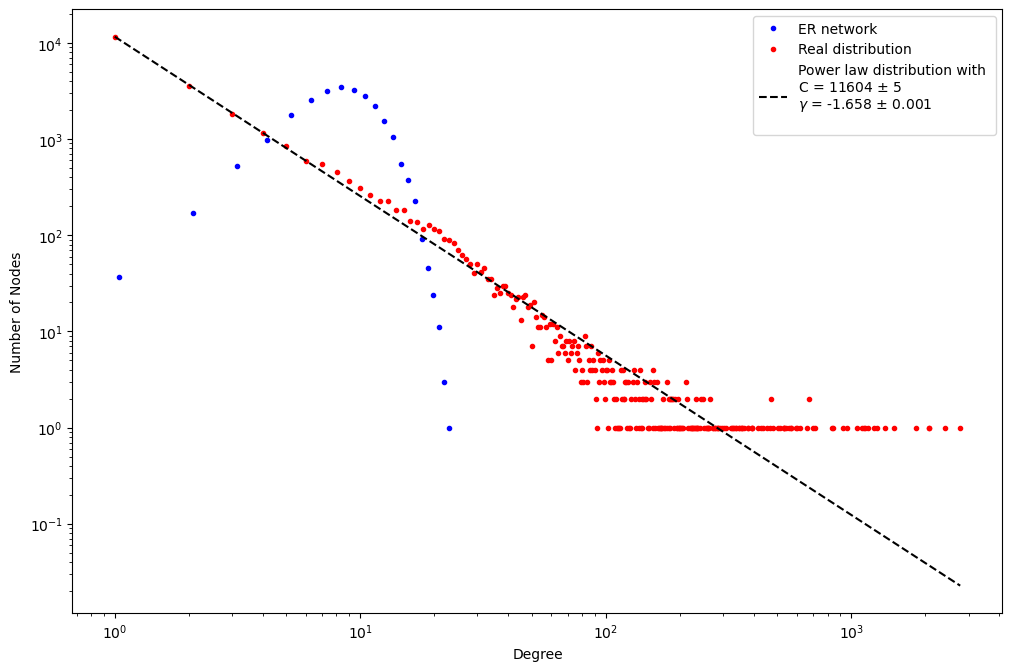

In [61]:
er = nx.fast_gnp_random_graph(n_nodes, prob,seed=1,directed=True)
fig=plt.figure(figsize=(12,8), dpi= 100)
#compute probability distribution for ER and real graph
hist_er = np.array(nx.degree_histogram(er))
hist = np.array(nx.degree_histogram(G))
#plot degree distribution for ER and real graph
x = np.linspace(0,len(hist_er),len(hist_er))
plt.plot(x, hist_er, ".", label="ER network",color="blue")
xx = np.linspace(1,len(hist),len(hist)-1)
plt.plot(xx, hist[1:], ".",label = "Real distribution",color="red")
#compute best parameter to approximate real distribution
popt, pcov = curve_fit(func, xx, hist[1:],p0=(1e8,-2))
err_0 = np.sqrt(pcov[0][0]) 
err_1 = np.sqrt(pcov[1][1])

chi = ((hist[1:]-func(xx, *popt))**2/func(xx, *popt)).sum()
adj_chi = chi/(len(hist[1:]-2))
label="Power law distribution with \nC = {:.0f} $\pm$ {:.0f} \n$\gamma$ = {:.3f} $\pm$ {:.3f}\n".format(popt[0],err_0,popt[1],err_1)
plt.plot(xx, func(xx, *popt), color ='black',label=label,ls="--")
# nice plot
plt.loglog()
plt.xlabel("Degree")
plt.ylabel("Number of Nodes")
plt.legend()
plt.savefig("images/random_conf.png")
plt.show()

<p> Lastly I carried out a basic graph analysis of the ER graph</p>

In [9]:
# clustering and density analysis
a_cluster = nx.average_clustering(er)
density = nx.density(er)
print("Avarage clustering coefficient: {:.5f} \nDensity: {:.5f}".format(a_cluster,density))

Avarage clustering coefficient: 0.00017 
Density: 0.00017


In [10]:
#connected component analysis
n_strong = nx.number_strongly_connected_components(er)
n_weak = nx.number_weakly_connected_components(er)
print(nx.is_strongly_connected(er),n_strong,n_weak)

False 746 8


In [11]:
#regime analysis
mean_k = (n_nodes-1)*prob
print("<k>={:.0f} \nln(N)= {:.0f} \nThis means we are in the supercritical regime".format(mean_k,np.log(n_nodes)))

<k>=4 
ln(N)= 10 
This means we are in the supercritical regime


In [20]:
# shortest path analysis
comps = list(nx.weakly_connected_components(er))
mean_short_lenght = nx.average_shortest_path_length(er.subgraph(comps[0]))
print("average shortest path lenght {:.2f}".format(mean_short_lenght))

average shortest path lenght 6.89


lastly I computed the k_max and k_min of the ER graph 

In [12]:
deg=[]
for tup in nx.degree(er):
    deg.append(tup[1])
    
print("K_max of ER model {}" .format(max(deg)))
print("K_min of ER model {}" .format(min(deg)))

K_max of ER model 23
K_min of ER model 0


In [13]:
deg=[]
for tup in nx.degree(G):
    deg.append(tup[1])
    
print("K_max of real graph {}" .format(max(deg)))
print("K_min of real graph {}" .format(min(deg)))

K_max of real graph 2774
K_min of real graph 1


## Configuration model

In [65]:
#create a configuration model network from our original network
din = list(d for n, d in G.in_degree())
dout = list(d for n, d in G.out_degree())
cm = nx.directed_configuration_model(din, dout,seed=4)
cm = nx.DiGraph(cm)

NetworkXError: random_state_index is incorrect

In [52]:
cm.number_of_edges()

NameError: name 'cm' is not defined

In [16]:
#connected component analysis
n_strong = nx.number_strongly_connected_components(cm)
n_weak = nx.number_weakly_connected_components(cm)
print(nx.is_strongly_connected(cm),n_strong,n_weak)

False 21296 7


In [51]:
# clustering and density analysis
a_cluster = nx.average_clustering(cm)
density = nx.density(cm)
print("Avarage clustering coefficient: {:.5f} \nDensity: {:.6f}".format(a_cluster,density))

NameError: name 'cm' is not defined

In [18]:
# shortest path analysis biggest component
comps = list(nx.weakly_connected_components(cm))
mean_short_lenght = nx.average_shortest_path_length(cm.subgraph(comps[0]))
print("average shortest path lenght {:.2f}".format(mean_short_lenght))

average shortest path lenght 0.70


## Configuration vs Er

In [21]:
dict_res = {}
lst_index = ["weakly connected components","Avg clustering coeffincient","density","k_max","k_min","<k>","avg shortest path","distribution"]
lst_er  = [8,0.00017,0.00017,23,0,4,6.89,"poissonian"]
dict_res["Er Graph"] = lst_er
lst_cm = [7,0.03459,0.00017,2774,1,"same as real",0.70,"same as real"]
dict_res["Configuration Graph"] = lst_cm
pd.DataFrame(dict_res,index=lst_index)

,Er Graph,Configuration Graph
weakly connected components,8,7
Avg clustering coeffincient,0.00017,0.03459
density,0.00017,0.00017
k_max,23,2774
k_min,0,1
<k>,4,same as real
avg shortest path,6.89,0.7
distribution,poissonian,same as real


## Appendice: Does the graph follow a power law distribution?

Due to the discrete nature of the degree distribution, for degree with small value the noise can be too high and it is difficult to understand if the distribution follows a power law. <br>
For this reason I used a logaritmic binning to better visualize the tail of the distribution.

[  73.           80.72104343   88.08740722   96.66105173  105.50988646
  116.20834123  126.83799223  139.48824816  152.75710233  167.75195684
  183.09052598  201.4018264   220.32726225  241.5218146   264.655345
  290.41402424  318.00189829  348.64260458  382.08125304  418.58648784
  459.45274697  503.00273887  551.0901568   604.10265384  662.46510354
  726.14317365  795.64724297  871.53669426  955.92461938 1047.48297614
 1147.9482403  1258.1276003  1379.40574667 1511.25231345 1656.73003399
 1815.50367986 1990.34985811 2180.66774904 2390.49087517]


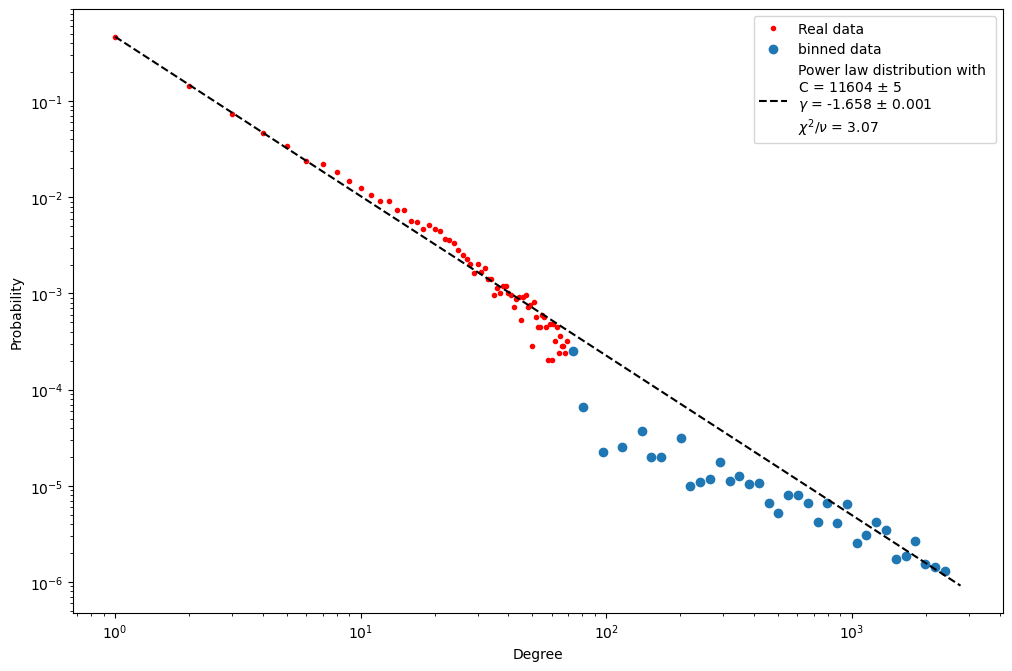

In [44]:
START = 70
tail = np.array(hist[START:])
binned,xx = log_binning(tail,40,start=START)
x = np.linspace(1,len(hist),len(hist)-1)
fig=plt.figure(figsize=(12,8), dpi= 100)

new_hist = np.concatenate((hist[1:START],binned))
new_bins = np.concatenate((x[:START-1],xx))

real_bin = np.concatenate((hist[1:START],binned))
expected = np.concatenate((func(x[:START-1],*popt),func(xx,*popt)))
chi = ((real_bin-expected)**2/expected).sum()
adj_chi = chi/(len(real_bin-2))

plt.loglog()
plt.plot(x[:START-1], hist[1:START]/hist.sum(), ".",label = "Real data",color="red")
plt.plot(xx, binned/hist.sum(),"o",label="binned data")
label="Power law distribution with \nC = {:.0f} $\pm$ {:.0f} \n$\gamma$ = {:.3f} $\pm$ {:.3f}\n$\chi^2$/$\\nu$ = {:.2f}".format(popt[0],err_0,popt[1],err_1,adj_chi)
plt.plot(x, func(x, *popt)/hist.sum(), color ='black',label=label,ls="--")
plt.ylabel("Probability")
plt.xlabel("Degree")
plt.legend()
plt.savefig("images/binned_power_law.png")
plt.show()


Lastly i computed the $\chi^2$ to test the hypothesis that the data follows a powerlaw distribution.

It is very clear from the value of $\frac{\chi^2}{\nu}$ that the data does not follow a power law distribution